# Lib

In [2]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

In [5]:
np.linspace(0, 1, 100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [16]:
x_s = []
y_s = []
z_s = []
w_s = []
for x in np.linspace(-2, 2, 100):
    for y in np.linspace(-2, 2, 100):
        for z in np.linspace(-2, 2, 100):
            for w in np.linspace(-2, 2, 100):

                if x**2 + y**2 + z**2 + w**2 < 1:
                    x_s += [x]
                    y_s += [y]
                    z_s += [z]
                    w_s += [w]

In [53]:
step_size = 1000
X = torch.tensor([x_s[::step_size], y_s[::step_size], z_s[::step_size], w_s[::step_size]]).transpose(0,1)

In [63]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, perplexity=30)
    x_2d = tsne.fit_transform(x)

    return x_2d

In [64]:
X_2d = get_2d_tsne(X)

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


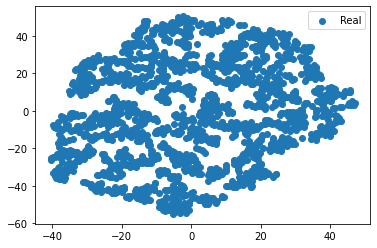

In [65]:
plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], label='Real')
plt.legend()

# Dataset

In [66]:
from dataset import customdataset

In [67]:
img_size = 32
channels = 3
batch_size = 100

In [68]:
# Train
train_dataset_normal = customdataset.get_nomral_dataset_train(dataset_name='cifar10',
                                                               label=0,
                                                               img_size=img_size, channels=channels,
                                                               data_path='./CIFAR10', download=True)

train_indx = SubsetRandomSampler(list(range(1000)))
train_loader_normal = DataLoader(train_dataset_normal, batch_size=batch_size, sampler=train_indx)

Files already downloaded and verified


In [69]:
# Test
test_dataset_normal,  test_dataset_ano = customdataset.get_dataset_test(dataset_name='cifar10',
                                                                         normal_label=0, ano_label=2,
                                                                         img_size=img_size, channels=channels,
                                                                         data_path="./CIFAR10", download=True)

test_loader_normal = DataLoader(test_dataset_normal, batch_size = test_dataset_normal.__len__())
test_loader_ano = DataLoader(test_dataset_ano, batch_size = test_dataset_ano.__len__())

Files already downloaded and verified
Files already downloaded and verified


# UNet

In [7]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")


        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.tanh(self.conv(dec1)), bottleneck

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [10]:
# TEST
N, C, H, W = 10, 3, 32, 32

unet = UNet(3,3,8).cuda()
x = torch.ones(N, C, H, W).cuda()

print(unet(x)[0].shape)
print(unet(x)[1].shape)

torch.Size([10, 3, 32, 32])
torch.Size([10, 128, 2, 2])


# Train

### Hyper

In [52]:
radius = 1
device = 'cpu'
unet = UNet(channels, channels, init_features=32).to(device)
optimizer_UNet = optim.Adam(unet.parameters())
critic = nn.MSELoss()

In [60]:
loss_min = np.Inf
best_unet = {}

for epoch in range(1000):
    # Training
    unet.train()
    for real_images, _ in train_loader_normal:
        real_images = real_images.to(device)
        optimizer_UNet.zero_grad()
        real_images_hat,  bottleneck = unet(real_images)
        bottleneck = bottleneck.flatten(1)

        loss_manifold = torch.relu( radius**2 - bottleneck.norm(dim=1, p=2) ).mean()
        loss_image = critic(real_images_hat, real_images)

        loss = 0.5*(loss_image + loss_manifold)

        loss.backward()
        optimizer_UNet.step()


    # Eval
    unet.eval()
    for real_images, _ in test_loader_normal:
        real_images = real_images.to(device)
        real_images_hat,  bottleneck = unet(real_images)
        bottleneck = bottleneck.flatten(1)

        loss_manifold = torch.relu( radius**2 - bottleneck.norm(dim=1, p=2) ).mean()
        loss_image = critic(real_images_hat, real_images)

        loss = 0.5*(loss_image + loss_manifold)

    # Save best Model
    loss_Total = loss.item()
    print(f"Epoch{epoch} : Loss = {loss_Total}")
    if loss_Total<loss_min:
        loss_min = loss_Total
        best_unet['epoch'] = epoch
        best_unet['loss'] = loss_Total
        best_unet['unet_parameters'] = unet.state_dict()

Epoch0 : Loss = 0.0072868079878389835
Epoch1 : Loss = 0.005264928564429283


KeyboardInterrupt: 

### Best UNet

In [ ]:
device = 'cuda'
unet = UNet(channels, channels, init_features=32).to(device)
unet.load_state_dict(
    best_unet['unet_parameters']
)

### TSNE

In [61]:
for real_images, _ in test_loader_normal:
    real_images = real_images.to(device)

In [62]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2, random_state=0,  learning_rate='auto', init='random')
    x_2d = tsne.fit_transform(x)

    return x_2d

In [63]:
_,  bottleneck = unet(real_images)

bottleneck = bottleneck.flatten(1)
real_images = real_images.flatten(1)

In [64]:
real_images_2d = get_2d_tsne(real_images.detach().cpu())
bottleneck_2d = get_2d_tsne(bottleneck.detach().cpu())

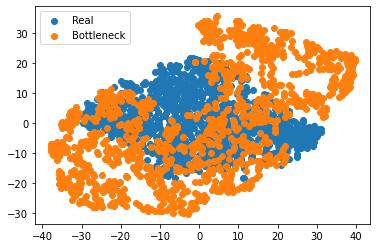

In [65]:
plt.figure()
plt.scatter(real_images_2d[:,0], real_images_2d[:,1], label='Real')
plt.scatter(bottleneck_2d[:,0], bottleneck_2d[:,1], label='Bottleneck')
plt.legend()

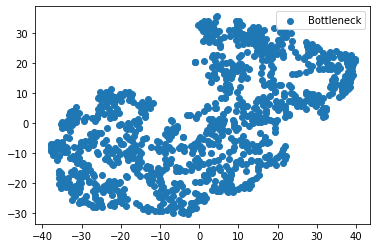

In [71]:
plt.figure()
plt.scatter(bottleneck_2d[:,0], bottleneck_2d[:,1], label='Bottleneck')
plt.legend()